In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [211]:
df = pd.read_csv('out_train_v2.csv')

In [212]:
df1 = pd.read_csv('out_test_v2.csv')

In [213]:
X = df.drop("WnvPresent", axis=1)
y = df.WnvPresent

In [214]:
X["TVar"] = X["Tmax"] - X["Tmin"]

In [215]:
df1["TVar"] = df1['Tmax'] - df1['Tmin']

In [216]:
X.head()
X = X.drop(['Unnamed: 0', 'Date', 'Address', 'Block', 'Street', 'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy', 'Tavg', 'Tmin', 'NumMosquitos', 'DewPoint'], axis=1)

In [217]:
test = df1.drop(['Unnamed: 0','Id', 'Date', 'Address', 'Block', 'Street', 'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy', 'Tavg', 'Tmin', 'DewPoint'], axis=1)

In [218]:
X.head()

Species  Trap  Tmax  PrecipTotal  AvgSpeed  length_of_day  \
0  CULEX PIPIENS/RESTUANS  T002    88          0.0       6.5          896.0   
1          CULEX RESTUANS  T002    88          0.0       6.5          896.0   
2          CULEX RESTUANS  T007    88          0.0       6.5          896.0   
3  CULEX PIPIENS/RESTUANS  T015    88          0.0       6.5          896.0   
4          CULEX RESTUANS  T015    88          0.0       6.5          896.0   

   TVar  
0    28  
1    28  
2    28  
3    28  
4    28

In [219]:
test.head()

Species  Trap  Tmax  PrecipTotal  AvgSpeed  length_of_day  \
0  CULEX PIPIENS/RESTUANS  T002    86          0.0      10.0          910.0   
1          CULEX RESTUANS  T002    86          0.0      10.0          910.0   
2           CULEX PIPIENS  T002    86          0.0      10.0          910.0   
3        CULEX SALINARIUS  T002    86          0.0      10.0          910.0   
4         CULEX TERRITANS  T002    86          0.0      10.0          910.0   

   TVar  
0    25  
1    25  
2    25  
3    25  
4    25

In [220]:
X.Species = X.Species.astype('category')
X.Species = X.Species.cat.codes

In [221]:
test.Species = test.Species.astype('category')
test.Species = test.Species.cat.codes

In [222]:
X.dtypes

Species             int8
Trap              object
Tmax               int64
PrecipTotal      float64
AvgSpeed         float64
length_of_day    float64
TVar               int64
dtype: object

In [223]:
X.Trap = X.Trap.astype('category')
X.Trap = X.Trap.cat.codes

In [224]:
test.Trap = test.Trap.astype('category')
test.Trap = test.Trap.cat.codes

In [225]:
X.dtypes

Species             int8
Trap               int16
Tmax               int64
PrecipTotal      float64
AvgSpeed         float64
length_of_day    float64
TVar               int64
dtype: object

In [226]:
test.dtypes

Species             int8
Trap               int16
Tmax               int64
PrecipTotal      float64
AvgSpeed         float64
length_of_day    float64
TVar               int64
dtype: object

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

In [30]:
X = StandardScaler().fit_transform(X)

In [31]:
test = StandardScaler().fit_transform(test)

In [33]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, roc_curve, auc

In [34]:
knn = KNeighborsClassifier(n_neighbors = 2)

In [35]:
names = ["present", "not present", "predicted present", "predicted not present"]

In [227]:
def evaluate_model(model, X, y, names, test):
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=7)
    model = model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    print model.score(X_test, Y_test)
    Y_pp = pd.DataFrame(model.predict_proba(X_test), columns=['class_0_pp','class_1_pp'])
    Y_pp['pred_class_thresh10'] = [1 if x >= 0.05 else 0 for x in Y_pp.class_1_pp.values]
    X_test_df = pd.DataFrame(X_test)
    conmat = np.array(confusion_matrix(Y_test, Y_pp.pred_class_thresh10, labels=[1,0]))
    confusion = pd.DataFrame(conmat, index=[names[0:2]],
                         columns=[names[2:]]) 
    print(Y_pp.iloc[0:10])
    print confusion
    print(classification_report(Y_test, Y_pp.pred_class_thresh10))
    print Y_pp.shape
    print X_test_df.head()
    
    Y_score = model.decision_function(X_test)

    FPR = dict()
    TPR = dict()
    ROC_AUC = dict()

# For class 1, find the area under the curve
    FPR[1], TPR[1], _ = roc_curve(Y_test, Y_score)
    ROC_AUC[1] = auc(FPR[1], TPR[1])

# Plot of a ROC curve for class 1 (has_cancer)
    plt.figure(figsize=[11,9])
    plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.title('Receiver operating characteristic for cancer detection', fontsize=18)
    plt.legend(loc="lower right")
    plt.show()
    return "cross val mean score is", cross_val_score(model, X_train, Y_train, cv=5).mean()
    
    


evaluate_model(knn, X, y, names, test)

0.942601672916
   class_0_pp  class_1_pp  pred_class_thresh10
0         0.5         0.5                    1
1         1.0         0.0                    0
2         1.0         0.0                    0
3         1.0         0.0                    0
4         1.0         0.0                    0
5         1.0         0.0                    0
6         1.0         0.0                    0
7         1.0         0.0                    0
8         1.0         0.0                    0
9         1.0         0.0                    0
             predicted present  predicted not present
present                     68                    114
not present                319                   2966
             precision    recall  f1-score   support

          0       0.96      0.90      0.93      3285
          1       0.18      0.37      0.24       182

avg / total       0.92      0.88      0.90      3467

(3467, 3)
       Species  Trap  Tmax  PrecipTotal  AvgSpeed  length_of_day  TVar
10156     

AttributeError: 'KNeighborsClassifier' object has no attribute 'decision_function'

In [38]:
model = knn.fit(X, y)
y_pred = model.predict(test)

In [40]:
len(y_pred)

116293

In [78]:
evaluate_model(knn, X1, y, names, test)

0.940871070089
   class_0_pp  class_1_pp  pred_class_thresh10
0         0.0         1.0                    1
1         1.0         0.0                    0
2         1.0         0.0                    0
3         1.0         0.0                    0
4         1.0         0.0                    0
5         1.0         0.0                    0
6         1.0         0.0                    0
7         1.0         0.0                    0
8         1.0         0.0                    0
9         1.0         0.0                    0
             predicted present  predicted not present
present                     57                    125
not present                310                   2975
             precision    recall  f1-score   support

          0       0.96      0.91      0.93      3285
          1       0.16      0.31      0.21       182

avg / total       0.92      0.87      0.89      3467

(3467, 3)
          0         1         2         3         4         5
0 -1.177499  1.3860

AttributeError: 'KNeighborsClassifier' object has no attribute 'decision_function'

In [228]:
rf = RandomForestClassifier(n_jobs=-1, max_features='sqrt')


In [230]:
evaluate_model(rf, X, y, names, test)

0.92529564465
   class_0_pp  class_1_pp  pred_class_thresh10
0        0.34        0.66                    1
1        1.00        0.00                    0
2        1.00        0.00                    0
3        1.00        0.00                    0
4        1.00        0.00                    0
5        1.00        0.00                    0
6        1.00        0.00                    0
7        1.00        0.00                    0
8        1.00        0.00                    0
9        1.00        0.00                    0
             predicted present  predicted not present
present                     93                     89
not present                579                   2706
             precision    recall  f1-score   support

          0       0.97      0.82      0.89      3285
          1       0.14      0.51      0.22       182

avg / total       0.92      0.81      0.85      3467

(3467, 3)
       Species  Trap  Tmax  PrecipTotal  AvgSpeed  length_of_day  TVar
10156      

AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

In [80]:
evaluate_model(rf, X1, y, names)

0.931352754543
   class_0_pp  class_1_pp  pred_class_thresh10
0         0.6         0.4                    1
1         1.0         0.0                    0
2         1.0         0.0                    0
3         1.0         0.0                    0
4         1.0         0.0                    0
5         1.0         0.0                    0
6         1.0         0.0                    0
7         1.0         0.0                    0
8         1.0         0.0                    0
9         1.0         0.0                    0
             predicted present  predicted not present
present                     94                     88
not present                574                   2711
             precision    recall  f1-score   support

          0       0.97      0.83      0.89      3285
          1       0.14      0.52      0.22       182

avg / total       0.93      0.81      0.86      3467

(3467, 3)
          0         1         2         3         4         5
0 -1.177499  1.3860

AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

In [231]:
#gradient boosting
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()

0.946351312374
   class_0_pp  class_1_pp  pred_class_thresh10
0    0.704790    0.295210                    1
1    0.906035    0.093965                    1
2    0.995107    0.004893                    0
3    0.977375    0.022625                    0
4    0.964203    0.035797                    0
5    0.982824    0.017176                    0
6    0.990278    0.009722                    0
7    0.998218    0.001782                    0
8    0.998497    0.001503                    0
9    0.998291    0.001709                    0
             predicted present  predicted not present
present                    147                     35
not present                890                   2395
             precision    recall  f1-score   support

          0       0.99      0.73      0.84      3285
          1       0.14      0.81      0.24       182

avg / total       0.94      0.73      0.81      3467

(3467, 3)
       Species  Trap  Tmax  PrecipTotal  AvgSpeed  length_of_day  TVar
10156     

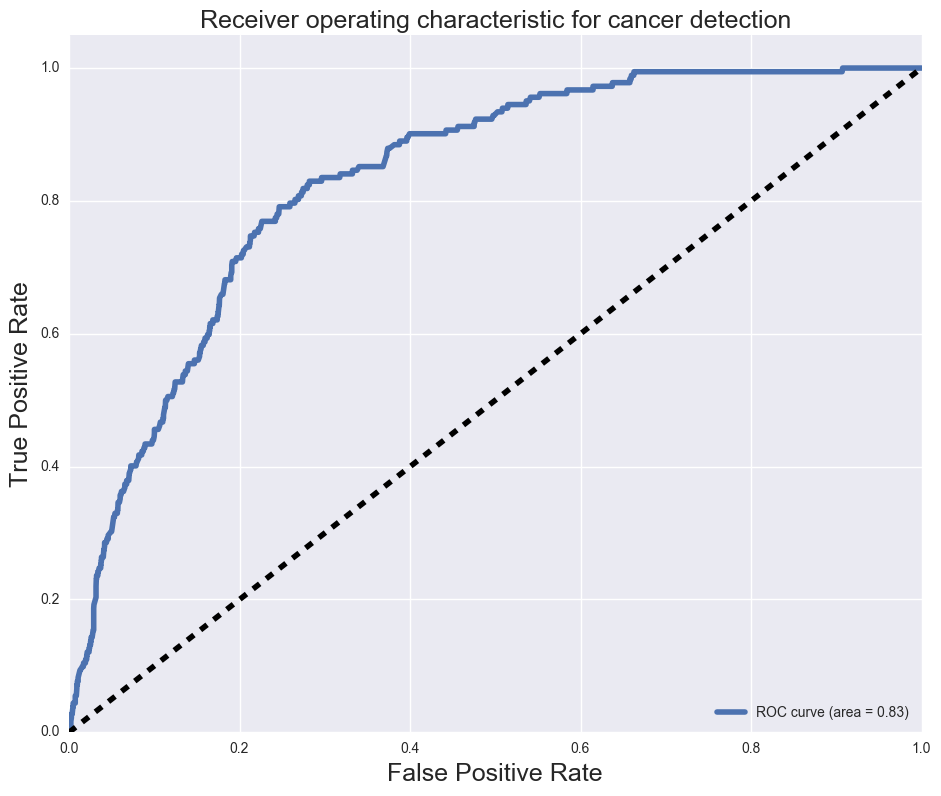

('cross val mean score is', 0.94729406942559924)

In [232]:
evaluate_model(gbc, X, y, names, test)

In [ ]:
max_features="sqrt", max_depth=3, random_state=42

In [152]:
svc = SVC(kernel='linear')

In [233]:
model = gbc.fit(X, y)
y_pred = model.predict_proba(test)

In [234]:
y_preds = pd.DataFrame(data=y_pred, columns=["WnvNotPresent", "WnvPresent"])

In [235]:
y_preds.head()

WnvNotPresent  WnvPresent
0       0.993513    0.006487
1       0.997285    0.002715
2       0.994675    0.005325
3       0.998199    0.001801
4       0.998199    0.001801

In [236]:
df_out = pd.merge(df1, y_preds[['WnvPresent']], how = 'left', left_index=True, right_index=True )

In [247]:
df_plot = pd.merge(df, y_preds[['WnvPresent']], how='left', left_index = True, right_index=True)

In [249]:
df_plot

Unnamed: 0        Date  \
0               0  2007-05-29   
1               1  2007-05-29   
2               2  2007-05-29   
3               3  2007-05-29   
4               4  2007-05-29   
5               5  2007-05-29   
6               6  2007-05-29   
7               7  2007-05-29   
8               8  2007-05-29   
9               9  2007-05-29   
10             10  2007-05-29   
11             11  2007-05-29   
12             12  2007-05-29   
13             13  2007-05-29   
14             14  2007-05-29   
15             15  2007-05-29   
16             16  2007-05-29   
17             17  2007-05-29   
18             18  2007-05-29   
19             19  2007-05-29   
20             20  2007-05-29   
21             21  2007-05-29   
22             22  2007-05-29   
23             23  2007-05-29   
24             24  2007-05-29   
25             25  2007-06-05   
26             26  2007-06-05   
27             27  2007-06-05   
28             28  2007-06-05   
29             29  2007-06-05   
...           ...         ...   
10476       10476  2013-09-26   
10477       10477  2013-09-26   
10478       10478  2013-09-26   
10479       10479  2013-09-26   
10480       10480  2013-09-26   
10481       10481  2013-09-26   
10482       10482  2013-09-26   
10483       10483  2013-09-26   
10484       10484  2013-09-26   
10485       10485  2013-09-26   
10486       10486  2013-09-26   
10487       10487  2013-09-26   
10488       10488  2013-09-26   
10489       10489  2013-09-26   
10490       10490  2013-09-26   
10491       10491  2013-09-26   
10492       10492  2013-09-26   
10493       10493  2013-09-26   
10494       10494  2013-09-26   
10495       10495  2013-09-26   
10496       10496  2013-09-26   
10497       10497  2013-09-26   
10498       10498  2013-09-26   
10499       10499  2013-09-26   
10500       10500  2013-09-26   
10501       10501  2013-09-26   
10502       10502  2013-09-26   
10503       10503  2013-09-26   
10504       10504  2013-09-26   
10505       10505  2013-09-26   

                                                 Address  \
0      4100 North Oak Park Avenue, Chicago, IL 60634,...   
1      4100 North Oak Park Avenue, Chicago, IL 60634,...   
2      6200 North Mandell Avenue, Chicago, IL 60646, USA   
3        7900 West Foster Avenue, Chicago, IL 60656, USA   
4        7900 West Foster Avenue, Chicago, IL 60656, USA   
5       1500 West Webster Avenue, Chicago, IL 60614, USA   
6         2500 West Grand Avenue, Chicago, IL 60654, USA   
7            1100 Roosevelt Road, Chicago, IL 60608, USA   
8            1100 Roosevelt Road, Chicago, IL 60608, USA   
9       1100 West Chicago Avenue, Chicago, IL 60642, USA   
10       2100 North Stave Street, Chicago, IL 60647, USA   
11       2200 North Cannon Drive, Chicago, IL 60614, USA   
12       2200 North Cannon Drive, Chicago, IL 60614, USA   
13        2200 West 113th Street, Chicago, IL 60643, USA   
14        2200 West 113th Street, Chicago, IL 60643, USA   
15      1100 South Peoria Street, Chicago, IL 60608, USA   
16         1700 West 95th Street, Chicago, IL 60643, USA   
17         2200 West 89th Street, Chicago, IL 60643, USA   
18         2200 West 89th Street, Chicago, IL 60643, USA   
19          North Streeter Drive, Chicago, IL 60611, USA   
20          North Streeter Drive, Chicago, IL 60611, USA   
21     6500 North Oak Park Avenue, Chicago, IL 60631,...   
22      7500 North Oakley Avenue, Chicago, IL 60645, USA   
23        1500 North Long Avenue, Chicago, IL 60651, USA   
24     8900 South Carpenter Street, Chicago, IL 60620...   
25     4100 North Oak Park Avenue, Chicago, IL 60634,...   
26     4100 North Oak Park Avenue, Chicago, IL 60634,...   
27     4100 North Oak Park Avenue, Chicago, IL 60634,...   
28       7900 West Foster Avenue, Chicago, IL 60656, USA   
29       7900 West Foster Avenue, Chicago, IL 60656, USA   
...                                                  ...   
10476       South Cottage Grove Avenue, 

In [250]:
df_plot = df_plot[['Longitude', 'Latitude', 'WnvPresent_y']]

In [251]:
df_plot.head()

Longitude   Latitude  WnvPresent_y
0 -87.800991  41.954690      0.006487
1 -87.800991  41.954690      0.002715
2 -87.769279  41.994991      0.005325
3 -87.824812  41.974089      0.001801
4 -87.824812  41.974089      0.001801

In [252]:
df_plot.to_csv('dfplot.csv', index=False)

In [245]:
df_out = df_out[['Id', 'WnvPresent']]

In [238]:
df_out.head()


Id  WnvPresent
0   1    0.006487
1   2    0.002715
2   3    0.005325
3   4    0.001801
4   5    0.001801

In [239]:
df_out.WnvPresent.value_counts()

0.001491    540
0.001335    288
0.002139    224
0.001230    192
0.001375    192
0.001387    180
0.012355    180
0.007192    180
0.008715    180
0.005726    180
0.004189    180
0.011460    180
0.001851    180
0.002266    180
0.001906    180
0.004818    180
0.002512    180
0.001373    180
0.011453    180
0.004129    180
0.011459    180
0.005285    180
0.001610    180
0.001810    180
0.002794    180
0.004493    180
0.016049    180
0.003717    180
0.009459    180
0.002806    180
           ... 
0.027583      1
0.002254      1
0.000983      1
0.031424      1
0.002103      1
0.019726      1
0.004921      1
0.028785      1
0.025956      1
0.187066      1
0.031938      1
0.004749      1
0.011314      1
0.021910      1
0.004102      1
0.005145      1
0.011271      1
0.082727      1
0.054658      1
0.028822      1
0.057212      1
0.010759      1
0.115371      1
0.002668      1
0.002180      1
0.006499      1
0.001947      1
0.046864      1
0.045322      1
0.011773      1
Name: WnvPresent, dtype:

In [240]:
df_out.to_csv('evaluation2_gbc_base_tvar.csv', index=False)

0.947216613787
   class_0_pp  class_1_pp  pred_class_thresh10
0    0.711429    0.288571                    1
1    0.891541    0.108459                    1
2    0.995536    0.004464                    0
3    0.977633    0.022367                    0
4    0.963303    0.036697                    0
5    0.978420    0.021580                    0
6    0.990045    0.009955                    0
7    0.997598    0.002402                    0
8    0.998039    0.001961                    0
9    0.998240    0.001760                    0
             predicted present  predicted not present
present                    144                     38
not present                869                   2416
             precision    recall  f1-score   support

          0       0.98      0.74      0.84      3285
          1       0.14      0.79      0.24       182

avg / total       0.94      0.74      0.81      3467

(3467, 3)
       Species  Trap  Tmax  PrecipTotal  AvgSpeed  length_of_day
10156        1  

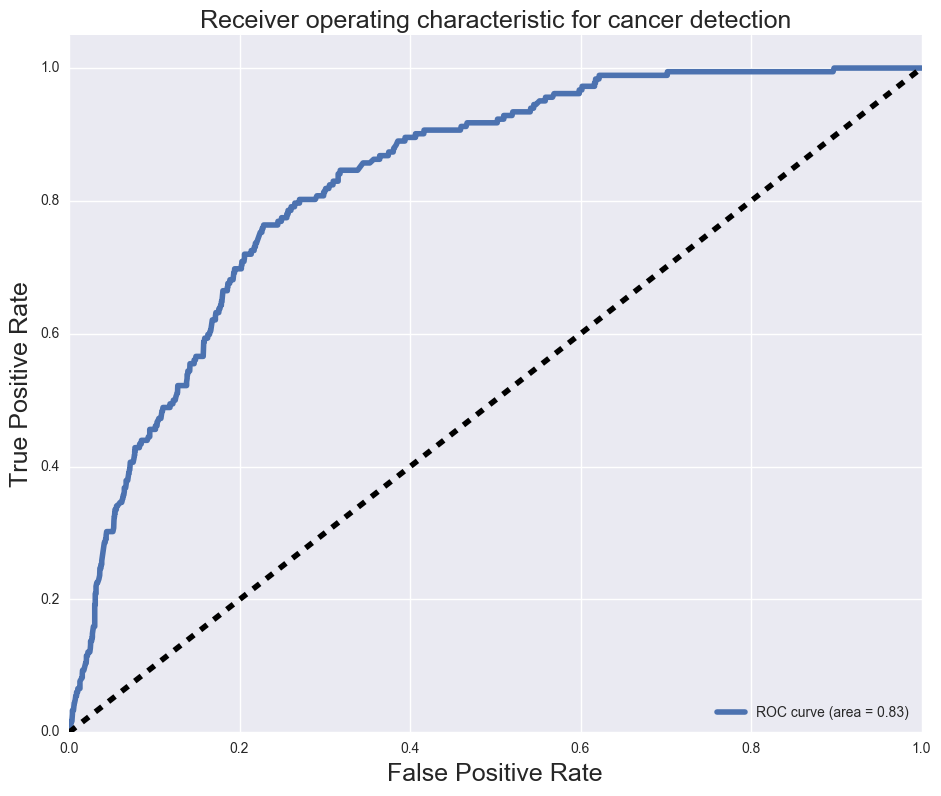

('cross val mean score is', 0.94672568569490212)

In [45]:
evaluate_model(gbc, X, y, names)

0.946351312374
   class_0_pp  class_1_pp  pred_class_thresh10
0    0.642486    0.357514                    1
1    0.912059    0.087941                    1
2    0.997693    0.002307                    0
3    0.979237    0.020763                    0
4    0.970193    0.029807                    0
5    0.983327    0.016673                    0
6    0.987240    0.012760                    0
7    0.998756    0.001244                    0
8    0.999036    0.000964                    0
9    0.999007    0.000993                    0
             predicted present  predicted not present
present                    146                     36
not present                874                   2411
             precision    recall  f1-score   support

          0       0.99      0.73      0.84      3285
          1       0.14      0.80      0.24       182

avg / total       0.94      0.74      0.81      3467

(3467, 3)
          0         1         2         3         4         5
0 -1.177499  1.3860

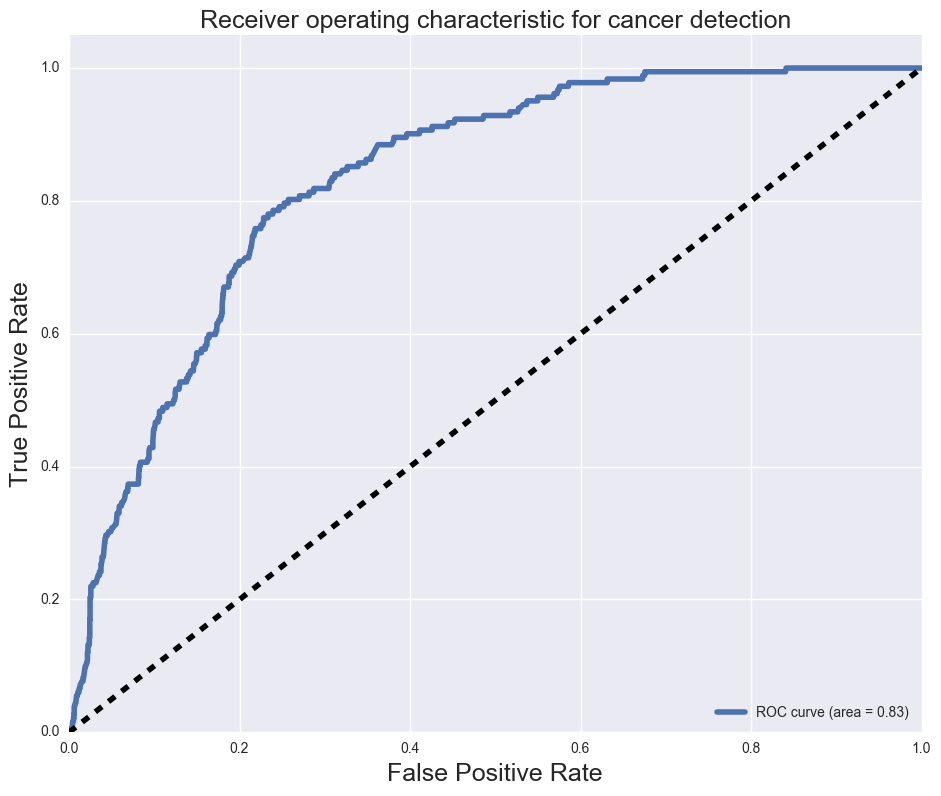

('cross val mean score is', 0.94715172110228085)

In [82]:
evaluate_model(gbc, X1, y, names)

## classifiers that don't work

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

#using support vector machine to classify. Have set the kernel to poly as polynomial kernels are better for natural language processing
#have set degree to 2 to prevent overfitting

lr = LogisticRegression()
svc = SVC(kernel='poly')

0.947505047592
   class_0_pp  class_1_pp  pred_class_thresh10
0    0.868016    0.131984                    1
1    0.913140    0.086860                    1
2    0.964026    0.035974                    0
3    0.936162    0.063838                    1
4    0.895359    0.104641                    1
5    0.884625    0.115375                    1
6    0.945818    0.054182                    1
7    0.985460    0.014540                    0
8    0.985396    0.014604                    0
9    0.974741    0.025259                    0
             predicted present  predicted not present
present                    114                     68
not present               1294                   1991
             precision    recall  f1-score   support

          0       0.97      0.61      0.75      3285
          1       0.08      0.63      0.14       182

avg / total       0.92      0.61      0.71      3467

(3467, 3)
       Species  Trap  Tmax  PrecipTotal  AvgSpeed  length_of_day
10156        1  

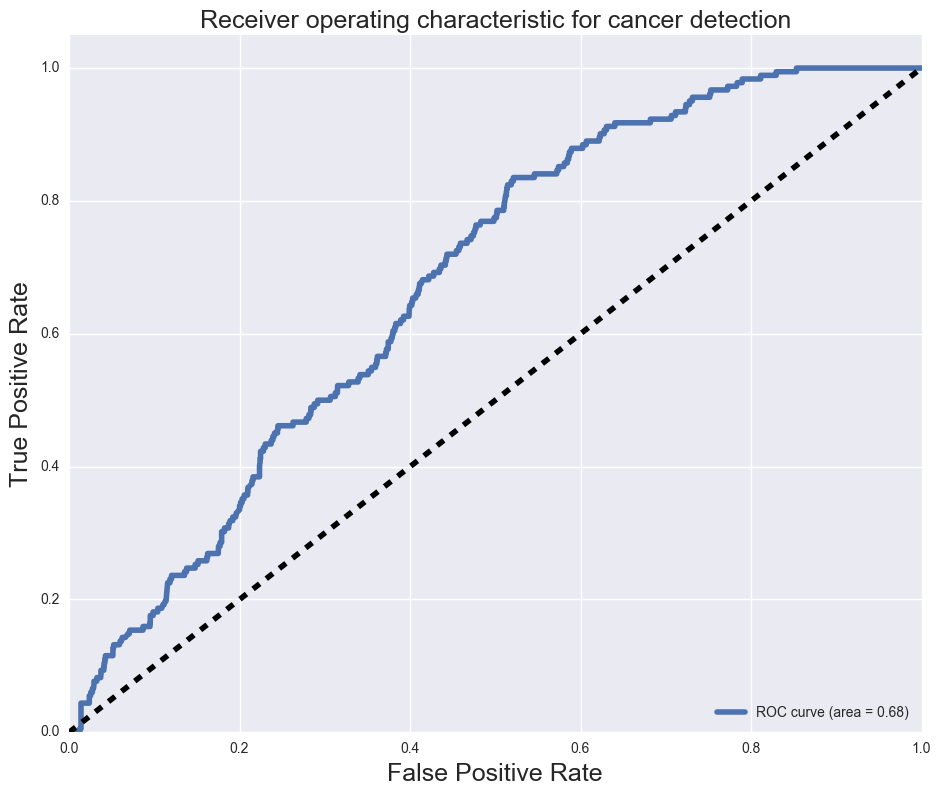

('cross val mean score is', 0.94757785746591716)

In [49]:
evaluate_model(lr, X, y, names)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=7)
model = svc.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
print model.score(X_test, Y_test)
# Y_pp = pd.DataFrame(model.predict_proba(X_test), columns=['class_0_pp','class_1_pp'])
# Y_pp['pred_class_thresh10'] = [1 if x >= 0.05 else 0 for x in Y_pp.class_1_pp.values]
# X_test_df = pd.DataFrame(X_test)
conmat = np.array(confusion_matrix(Y_test, Y_pred, labels=[1,0]))
confusion = pd.DataFrame(conmat, index=[names[0:2]],
                         columns=[names[2:]]) 
# print(Y_pp.iloc[0:10])
print confusion
print(classification_report(Y_test, Y_pred))
# print Y_pp.shape
# print X_test_df.head()
    
Y_score = model.decision_function(X_test)

FPR = dict()
TPR = dict()
ROC_AUC = dict()

# For class 1, find the area under the curve
FPR[1], TPR[1], _ = roc_curve(Y_test, Y_score)
ROC_AUC[1] = auc(FPR[1], TPR[1])

# Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for cancer detection', fontsize=18)
plt.legend(loc="lower right")
plt.show()
print "cross val mean score is", cross_val_score(model, X_train, Y_train, cv=5).mean()
    